In [3]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
import os
from qiskit.primitives import Estimator

In [4]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch import nn
import pandas as pd

from sklearn.decomposition import PCA

from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.log_ops import *
from Components.utils import *

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = 4)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


/home/ncng/.local/share/virtualenvs/VQA-Notes-v2-sVJD73WG/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


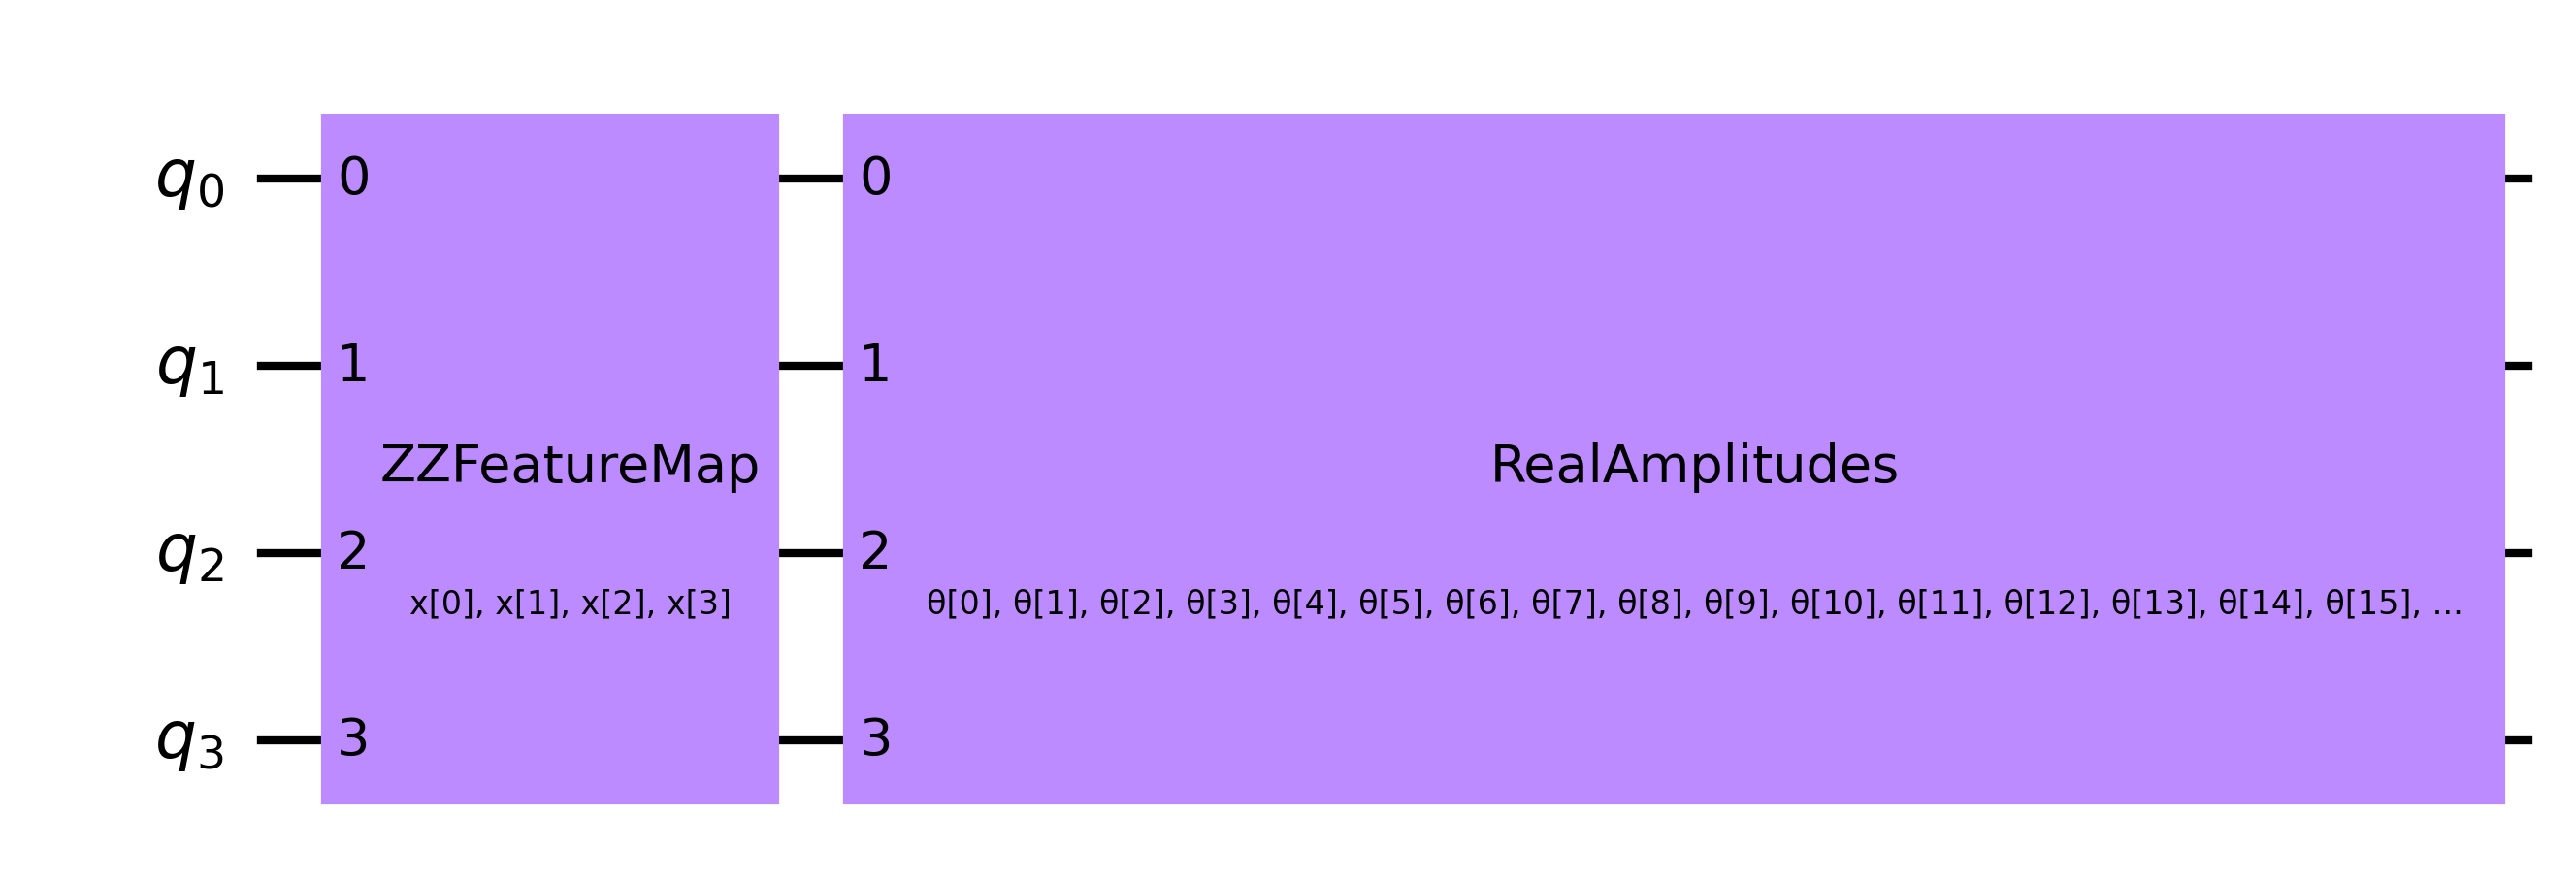

In [6]:
feature_map = featureMapGenerator(4)
ansatz = AnsatzGenerator(4, 4, ENTANGLEMENT)

qc = circuitBuilder(feature_map, ansatz, 'middle')
qc.draw('mpl')

In [16]:
res = pd.DataFrame()
GLOBAL_OPERATOR = SparsePauliOp.from_list([('Z'*qc.num_qubits, 1)])
for i in range(0, 1):
    print(f'Current Iteration: {i}')
    initial_point = np.random.uniform(0, np.pi/2, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=Estimator(),
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=initial_point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(initial_point, loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)


Current Iteration: 0
init: [0.76172217 0.42204353 1.25275185 1.3512148  1.29181818 0.81866811
 1.00867489 0.43179898 0.49424765 0.40599473 0.33818546 0.75577972
 0.18419321 1.21449298 0.63872363 0.24814207 1.35709639 0.49122065
 0.61983413 1.51209444]
weig: tensor([0.7617, 0.4220, 1.2528, 1.3512, 1.2918, 0.8187, 1.0087, 0.4318, 0.4942,
        0.4060, 0.3382, 0.7558, 0.1842, 1.2145, 0.6387, 0.2481, 1.3571, 0.4912,
        0.6198, 1.5121])


In [8]:
pd.DataFrame(res).to_csv('./bp-visualise/point-mae.csv')

In [9]:
data = pd.read_csv('bp-visualise/point-mae.csv', index_col=0)
display(data.head())

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.216448,0.430091,0.781360,0.758309,0.665775,0.538381,0.934161,1.217778,0.053628,1.148604,...,1.531524,1.140509,0.565726,1.241122,0.199782,0.513521,0.484033,1.136350,0.143906,1.072708
1,0.911559,0.331980,0.093697,0.015845,0.681504,0.147314,0.246297,1.249855,0.933982,0.220501,...,0.985009,0.258713,1.083662,0.651873,0.456034,1.347440,0.675381,0.269673,1.493800,1.021320
2,0.852628,0.223343,1.516273,0.033744,0.735473,0.279586,1.393434,1.497135,0.518323,1.358159,...,0.110479,0.816223,1.233621,0.056821,0.006420,1.015665,0.620735,0.678650,0.866793,0.966020
3,1.124689,1.175796,1.326784,1.199409,0.070472,0.631747,0.820293,0.228279,0.445562,1.360988,...,0.248110,0.513784,0.931047,0.462232,0.883972,0.894925,0.910203,0.573856,0.165712,1.037035
4,0.669834,0.084453,1.540283,0.317296,1.325980,1.349651,1.516722,0.378381,1.509420,0.480188,...,1.301816,1.138238,1.381836,0.561475,0.829478,1.013450,1.179043,0.236541,1.523220,0.995550


In [10]:
parameters = data.iloc[:,:-1]
maes = data.iloc[:,-1]

In [11]:
pca = PCA(n_components=2)
pca.fit(parameters)
principalData = pca.transform(parameters)
print(pca.explained_variance_ratio_)

[0.10406189 0.08825841]


In [12]:
principalDataDF = pd.DataFrame(principalData, columns=['x', 'y'])
principalDataDF['z'] = maes

In [13]:
principalDataDF.head()

,x,y,z
0,0.459733,-1.046835,1.072708
1,-0.459838,0.584841,1.021320
2,0.575072,0.666063,0.966020
3,0.641436,0.720674,1.037035
4,-0.504520,-0.426526,0.995550


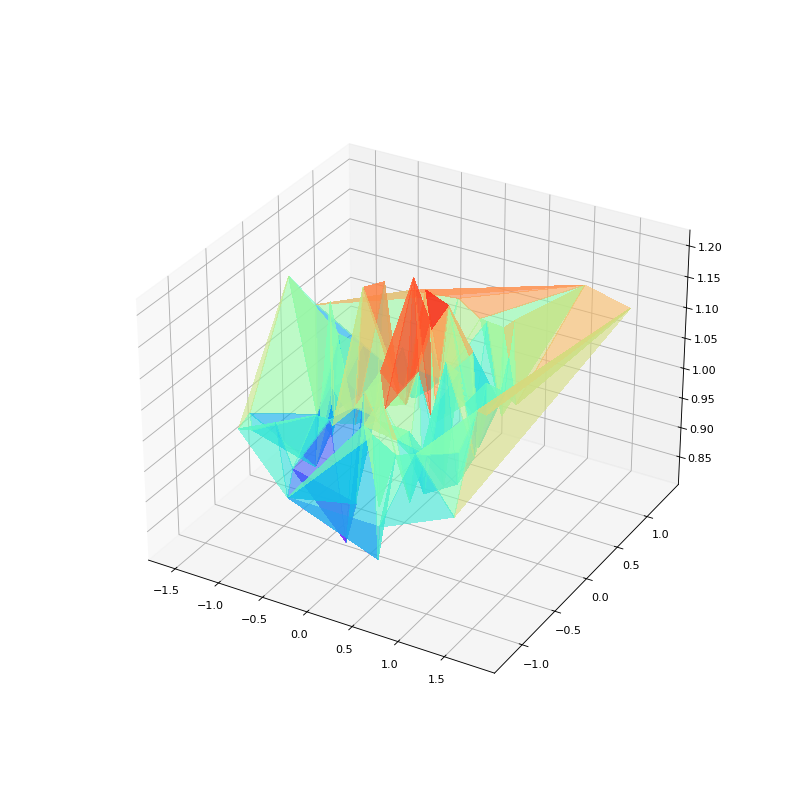

In [14]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

xs = principalDataDF['x']
ys = principalDataDF['y']
zs = principalDataDF['z']

fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(111, projection='3d')

plot = ax.plot_trisurf(xs, 
                       ys, 
                       zs,
                       cmap=plt.get_cmap('rainbow'),
                       linewidth=0,
                       antialiased=False,
                       alpha=0.6)

plt.show()